In [1]:
import numpy as np
import pandas as pd 
import scipy.spatial.distance as ds

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from transformers import BertTokenizer, BertModel
import numpy as np
import torch

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import wordnet as wn


import wordsegment
from wordsegment import load, segment
load()

import emoji
import emojis

import re
import string
from string import punctuation
import json

from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

from preprocessing import clean_first, clean_second, split_word, count_of_smiles
from preprocessing import penn2morphy, lem_pos, delete_stopwords, jaccard_similarity


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package punkt to /home/ivershin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ivershin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ivershin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ivershin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ivershin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ivershin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# JSON parsing

In [ ]:
d_train = [json.loads(line) for line in open('ranking_train.jsonl','r')]
d_test = [json.loads(line) for line in open('ranking_test.jsonl','r')]

comm = []
rank = []
uids = []
uid = 0

for post in d_train:
    for com in post['comments']:
        rank.append(com['score'])
        comm.append(com['text'])
        uids.append(uid)
    
    uid += 1
    
df_train = pd.DataFrame({'uid': uids, 'rank': rank, 'comm': comm})

comm = []
rank = []
uids = []
for post in d_test:
    for com in post['comments']:
        rank.append(com['score'])
        comm.append(com['text'])
        uids.append(uid)

    uid += 1


df_test = pd.DataFrame({'uid': uids, 'rank': rank, 'comm': comm})

df_train['comm'] = df_train['comm'].apply(lambda x: clear_text(x))
df_test['comm'] = df_test['comm'].apply(lambda x: clear_text(x))

df_train['comm_?!_ratio'] = df_train['comm'].apply(lambda x: len([xx.start() for xx in re.finditer('[!?]', x)])/len(x))
df_train['comm_tags'] = df_train['comm'].apply(lambda x: len([xx.start() for xx in re.finditer('#\w+', x)]))
df_train['comm_words'] = df_train['comm'].apply(lambda x: len(x.split()))
df_test['comm_?!_ratio'] = df_test['comm'].apply(lambda x: len([xx.start() for xx in re.finditer('[!?]', x)])/len(x))
df_test['comm_tags'] = df_test['comm'].apply(lambda x: len([xx.start() for xx in re.finditer('#\w+', x)]))
df_test['comm_words'] = df_test['comm'].apply(lambda x: len(x.split()))

df_train.to_csv('ranking_train_comments.csv', index=False)
df_test.to_csv('ranking_test_comments.csv', index=False)

# Prepare text for transformers

In [8]:
df = pd.read_csv('ranking_train_comments.csv')
df_test = pd.read_csv('ranking_test_comments.csv')

#### Обрабатываем смайлики

Запись смайлов (в виде картинок внутри текста) в отдельный признак

In [14]:
list_of_smiles = ['))', '((', ':D',  '=D', ':-D', ':-(', ':-)', ':)','=)', ':(', 'о_О', 'o.O', ':-*', ':*', '^_^', ';)', ';-)', ':p'] 

In [10]:
df['have_emoji'] = df['comm'].apply(lambda text: list(emojis.get(text)))
df_test['have_emoji'] = df_test['comm'].apply(lambda text: list(emojis.get(text)))

Замена смайлов на shortcode

In [11]:
df['comm'] = df['comm'].apply(lambda x: emoji.demojize(x))
df_test['comm'] = df_test['comm'].apply(lambda x: emoji.demojize(x))

In [ ]:
df.have_emoji.drop_duplicates()

0                                                       []
15009                                                  [⚫]
15171                                                  [😮]
26818                                                  [👍]
33331    [2️⃣, 6️⃣, 8️⃣, 0️⃣, 5️⃣, 7️⃣, 3️⃣, 9️⃣, 1️⃣, ...
56961                                                  [😊]
59879                                                  [😉]
61699                                                  [😁]
Name: have_emoji, dtype: object

Замена листа смайликов на их кол-во  в признаке 'have_emoji'

In [12]:
df['have_emoji'] = df['have_emoji'].apply(lambda smile: len(smile))
df_test['have_emoji'] = df_test['have_emoji'].apply(lambda smile: len(smile))

Ищем символьные смайлики, записываем кол-во символьных смайлов в признак 'count_smiles'

In [20]:
# df['count_smiles'] = df['comm'].apply(lambda smile: count_of_smiles(smile))
df_test['count_smiles'] = df_test['comm'].apply(lambda smile: count_of_smiles(smile, list_of_smiles))

Объединяем результаты

In [21]:
df['count_smiles'] = df.apply(lambda smile: smile['have_emoji'] + smile['count_smiles'], axis=1)
df_test['count_smiles'] = df_test.apply(lambda smile: smile['have_emoji'] + smile['count_smiles'], axis=1)
df =  df.drop(columns=['have_emoji'], axis = 1)
df_test = df_test.drop(columns=['have_emoji'], axis = 1)

#### Очищаем от неинтерпретируемых символов, заменяем ссылки и смайлики на специальный токен

In [7]:
df['comm']=df['comm'].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8") )
df['comm']=df['comm'].apply(lambda x: re.sub(r'\<[^>]+\>', '', x.lower()))
df['comm']=df['comm'].apply(lambda x: re.sub(r'\<[^>]*\>', '', x.lower()))
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
df['comm']=df['comm'].apply(lambda x: re.sub(CLEANR, '', x.lower()))
df['comm']=df['comm'].apply(lambda x: re.sub(r'(https?://[^\s]+)', 'URLURLURL', x.lower()))

WEB_URL_REGEX = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|~/.|https|.net|php|/.|[||]|config|biz|db|../|./|com|uk|co|info|ir|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
df['comm']=df['comm'].apply(lambda x: re.sub(WEB_URL_REGEX, 'URLURLURL', x.lower()))

df['comm']=df['comm'].apply(lambda x: re.sub(r'([;:]-*([()\[\]])\2*)', 'SMILESMILE', x.lower()))

In [23]:
df_test['comm']=df_test['comm'].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8") )
df_test['comm']=df_test['comm'].apply(lambda x: re.sub(r'\<[^>]+\>', '', x.lower()))
df_test['comm']=df_test['comm'].apply(lambda x: re.sub(r'\<[^>]*\>', '', x.lower()))
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
df_test['comm']=df_test['comm'].apply(lambda x: re.sub(CLEANR, '', x.lower()))
df_test['comm']=df_test['comm'].apply(lambda x: re.sub(r'(https?://[^\s]+)', 'URLURLURL', x.lower()))

WEB_URL_REGEX = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|~/.|https|.net|php|/.|[||]|config|biz|db|../|./|com|uk|co|info|ir|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
df_test['comm']=df_test['comm'].apply(lambda x: re.sub(WEB_URL_REGEX, 'URLURLURL', x.lower()))

df_test['comm']=df_test['comm'].apply(lambda x: re.sub(r'([;:]-*([()\[\]])\2*)', 'SMILESMILE', x.lower()))

#### Создаем фичу, есть ли в комментарии слово, написанное КАПСОМ

In [24]:
df['any_upper']=df['comm'].apply(lambda y: 1 if any([word.isupper() for word in y.split()]) else 0 )
df_test['any_upper']=df_test['comm'].apply(lambda y: 1 if any([word.isupper() for word in y.split()]) else 0 )

#### Создаем фичу, есть ли в комментарии цифра

In [25]:
df['any_digit']=df['comm'].apply(lambda y: 1 if any([word.isdigit() for word in y.split()]) else 0 )
df_test['any_digit']=df_test['comm'].apply(lambda y: 1 if any([word.isdigit() for word in y.split()]) else 0 )

#### Очищаем текст 
от оставшихся символов и приводим английские слова в единообразную форму (isnt -> is not и т.п.)

In [26]:
df['comm'] = df['comm'].fillna('+')
df['comm'] =  [clean_first(r) for r in df['comm'].values]
df['comm'] = df['comm'].fillna('+') 

df_test['comm'] = df_test['comm'].fillna('+')
df_test['comm'] =  [clean_first(r) for r in df_test['comm'].values]
df_test['comm'] = df_test['comm'].fillna('+') 

При очистке от символов некоторые комментарии становятся пустыми - заменяем такие случаи на '+' (часто ставят в комментах + как согласие с чем-либо, поэтому такая замена имеет смысл)

In [27]:
df['post'] = df.groupby("uid", group_keys=False)["post"].apply(lambda x: x.ffill().bfill())

df['post'] = df['post'].fillna('+')
df['post'] =  [clean_first(r) for r in df['post'].values]
df['post'] = df['post'].fillna('+') 

df_test['post'] = df_test.groupby("uid", group_keys=False)["post"].apply(lambda x: x.ffill().bfill())

df_test['post'] = df_test['post'].fillna('+')
df_test['post'] =  [clean_first(r) for r in df_test['post'].values]
df_test['post'] = df_test['post'].fillna('+') 

Предполагаем, что всё, что содержит / (не удаляли ранее) - это ссылка

In [28]:
df['post']=df['post'].apply(lambda x: x.replace('/', 'urlurlurl'))
df['comm']=df['comm'].apply(lambda x: x.replace('/', 'urlurlurl'))

df_test['post']=df_test['post'].apply(lambda x: x.replace('/', 'urlurlurl'))
df_test['comm']=df_test['comm'].apply(lambda x: x.replace('/', 'urlurlurl'))

Удаляем некоторые символы, двойные пробелы, табуляции, а также разлепляем слова, которые слиплись через различную пунктуацию ('hello.word' -> 'hello word' и т.п.)

In [13]:
df['comm'] =  [clean_second(r) for r in df['comm'].values]
df['comm'] = df['comm'].fillna('+') 
df['post'] =  [clean_second(r) for r in df['post'].values]
df['post'] = df['post'].fillna('+') 

In [29]:
df_test['comm'] =  [clean_second(r) for r in df_test['comm'].values]
df_test['comm'] = df_test['comm'].fillna('+') 
df_test['post'] =  [clean_second(r) for r in df_test['post'].values]
df_test['post'] = df_test['post'].fillna('+') 

Разлепляем слова без пробела (anytypeyouwants -> any type you wants)

In [ ]:
k=[]
text = []
for t in tqdm_notebook(df['comm'].values):
    k=[]
    for j in t.split():
        if len(j) > 2 and j.isalpha():
            k+=[i for i in segment(j)]
        else:
            k+=[str(j)]
    text += [' '.join(k)]
df['comm'] = text

k=[]
text = []
for t in tqdm_notebook(df['post'].values):
    k=[]
    for j in t.split():
        if len(j) > 2 and j.isalpha():
            k+=[i for i in segment(j)]
        else:
            k+=[str(j)]
    text += [' '.join(k)]
df['post'] = text

In [30]:
k=[]
text = []
for t in tqdm_notebook(df_test['comm'].values):
    k=[]
    for j in t.split():
        if len(j) > 2 and j.isalpha():
            k+=[i for i in segment(j)]
        else:
            k+=[str(j)]
    text += [' '.join(k)]
df_test['comm'] = text

k=[]
text = []
for t in tqdm_notebook(df_test['post'].values):
    k=[]
    for j in t.split():
        if len(j) > 2 and j.isalpha():
            k+=[i for i in segment(j)]
        else:
            k+=[str(j)]
    text += [' '.join(k)]
df_test['post'] = text

  0%|          | 0/70020 [00:00<?, ?it/s]

  0%|          | 0/70020 [00:00<?, ?it/s]

In [31]:
df['post']=df['post'].apply(lambda x: x.replace("smile smile", "smilesmile"))
df['post']=df['post'].apply(lambda x: x.replace("url url url", "urlurlurl"))
df['comm']=df['comm'].apply(lambda x: x.replace("url url url", "urlurlurl"))
df['comm']=df['comm'].apply(lambda x: x.replace("smile smile", "smilesmile"))

df_test['post']=df_test['post'].apply(lambda x: x.replace("smile smile", "smilesmile"))
df_test['post']=df_test['post'].apply(lambda x: x.replace("url url url", "urlurlurl"))
df_test['comm']=df_test['comm'].apply(lambda x: x.replace("url url url", "urlurlurl"))
df_test['comm']=df_test['comm'].apply(lambda x: x.replace("smile smile", "smilesmile"))

Более корректно обрабатываем ссылки, смайлы и адреса почты

In [25]:
k=[]
text3 = []
for t in tqdm_notebook(df['comm']):
    k=[]
    if 'urlurlurl' in t :
        for j in t.split():
            if 'urlurlurl' not in j:
                k+=[j]
            else:
                k+=['URL']
        text3 += [' '.join(k)]
        
    else:
        text3 += [t]
df['comm']=text3

k=[]
text3 = []
for t in tqdm_notebook(df['comm']):
    k=[]
    if 'smilesmile' in t :
        for j in t.split():
            if 'smilesmile' not in j:
                k+=[j]
            else:
                k+=['SMILE']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df['comm']=text3

k=[]
text3 = []
for t in tqdm_notebook(df['comm']):
    k=[]
    if 'mail.' in t :
        for j in t.split():
            if 'mail.' not in j:
                k+=[j]
            else:
                k+=['MAIL']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df['comm']=text3

  0%|          | 0/440535 [00:00<?, ?it/s]

  0%|          | 0/440535 [00:00<?, ?it/s]

  0%|          | 0/440535 [00:00<?, ?it/s]

In [27]:
k=[]
text3 = []
for t in tqdm_notebook(df['post']):
    k=[]
    if 'urlurlurl' in t :
        for j in t.split():
            if 'urlurlurl' not in j:
                k+=[j]
            else:
                k+=['URL']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df['post']=text3

k=[]
text3 = []
for t in tqdm_notebook(df['post']):
    k=[]
    if 'smilesmile' in t :
        for j in t.split():
            if 'smilesmile' not in j:
                k+=[j]
            else:
                k+=['SMILE']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df['post']=text3

k=[]
text3 = []
for t in tqdm_notebook(df['post']):
    k=[]
    if 'mail.' in t :
        for j in t.split():
            if 'mail.' not in j:
                k+=[j]
            else:
                k+=['MAIL']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df['post']=text3

  0%|          | 0/440535 [00:00<?, ?it/s]

  0%|          | 0/440535 [00:00<?, ?it/s]

  0%|          | 0/440535 [00:00<?, ?it/s]

In [32]:
k=[]
text3 = []
for t in tqdm_notebook(df_test['comm']):
    k=[]
    if 'urlurlurl' in t :
        for j in t.split():
            if 'urlurlurl' not in j:
                k+=[j]
            else:
                k+=['URL']
        text3 += [' '.join(k)]
        
    else:
        text3 += [t]
df_test['comm']=text3

k=[]
text3 = []
for t in tqdm_notebook(df_test['comm']):
    k=[]
    if 'smilesmile' in t :
        for j in t.split():
            if 'smilesmile' not in j:
                k+=[j]
            else:
                k+=['SMILE']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df_test['comm']=text3

k=[]
text3 = []
for t in tqdm_notebook(df_test['comm']):
    k=[]
    if 'mail.' in t :
        for j in t.split():
            if 'mail.' not in j:
                k+=[j]
            else:
                k+=['MAIL']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df_test['comm']=text3

k=[]
text3 = []
for t in tqdm_notebook(df_test['post']):
    k=[]
    if 'urlurlurl' in t :
        for j in t.split():
            if 'urlurlurl' not in j:
                k+=[j]
            else:
                k+=['URL']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df_test['post']=text3

k=[]
text3 = []
for t in tqdm_notebook(df_test['post']):
    k=[]
    if 'smilesmile' in t :
        for j in t.split():
            if 'smilesmile' not in j:
                k+=[j]
            else:
                k+=['SMILE']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df_test['post']=text3

k=[]
text3 = []
for t in tqdm_notebook(df_test['post']):
    k=[]
    if 'mail.' in t :
        for j in t.split():
            if 'mail.' not in j:
                k+=[j]
            else:
                k+=['MAIL']
        text3 += [' '.join(k)]
    else:
        text3 += [t]
df_test['post']=text3

  0%|          | 0/70020 [00:00<?, ?it/s]

  0%|          | 0/70020 [00:00<?, ?it/s]

  0%|          | 0/70020 [00:00<?, ?it/s]

  0%|          | 0/70020 [00:00<?, ?it/s]

  0%|          | 0/70020 [00:00<?, ?it/s]

  0%|          | 0/70020 [00:00<?, ?it/s]

In [33]:
df.to_csv('train_for_transformers.csv', index=False)
df_test.to_csv('test_for_transformers.csv', index=False)

In [34]:
df_test['comm'].values[:50]

array(['i not still waiting for them to stabilize wifi on the i pad sith ios 8. their quality has really started to slip for me since 10. 9 on mac.',
       'for those who upgraded, no need to do a restore. you can just option-click update and downgrade the os back to 8. 0.0. instructions: URL',
       'upgraded shortly after it was released and suffered the consequences. just was able to restore back down to 8. 0i had to turn i notes sage off and back on again in order for apple to re-register my number.. until then i was unable to send to any existing contacts.',
       'i think they were under a lot of pressure on the health kit front. that was one of their big flagship ios 8 features, they got all these app developers to integrate it, then ios 8 shipped and they had a showstopper bug and wouldnt release any apps using healthkit.',
       'fix for those who already updated: URL',
       'get it from your employer. its better and cheaper than what you can get in the market. you are a

In [26]:
df['comm'].values[:50]

array(['going back to school is not with giving up. some founders go back to school and keep working on the startup while there. those do so much worse than the people who work on the startup that going back to school seems, in practice, not too far removed from a death sentence for a startup. off the top of my head, guess had about startups where the founders went back to school. it does not only happen with summer batches. founders from winter batches do it too. usually the reason is that the startup is not doing very well. that judgement depends a lot on how determined the founders are. one reason we now shy away from funding people still in school is that they often unconsciously want the startup to fail, because the of dropping out frightens them. a lot of startups look bad after months. someone whos out of school and has to make it work or get a job in a cubicle will say do not worry, well figure out how to make it successful.',
       'there will invariably be those who do not s

# BERT infer embs

In [1]:
max_len = 96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  max_length = max_len
                                  )
model.to(device)
print(model)

cpu


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [2]:
import pandas as pd

df = pd.read_csv('train_for_transformers.csv')
print(df.head())
df['comm'] = df['comm'].fillna('+')
texts = df['comm'].tolist()

   Unnamed: 0  uid  rank                                               comm  \
0           0    0     0  going back to school is not with giving up. so...   
1           1    0     1  there will invariably be those who do not see ...   
2           2    0     2  for me school is a way to be connected to what...   
3           3    0     3  i guess it really depends on how hungry you ar...   
4           4    0     4  i know poll ground to go back to school after ...   

                                                post  comm_words  comm_tags  \
0  how many summer y combinator fund decided not ...         181          0   
1  how many summer y combinator fund decided not ...          76          0   
2  how many summer y combinator fund decided not ...          92          0   
3  how many summer y combinator fund decided not ...          64          0   
4  how many summer y combinator fund decided not ...          14          0   

   comm_?!_ratio  count_smiles  any_upper  any_dig

In [3]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
embs = np.zeros(shape=(0, 768))
embs_out = 'train_comm_embs.npy'

beg = 0 #номер примера, с которого начинаем
batch_size = 1000 
for idx in tqdm(range(beg, len(texts), batch_size)):
    batch = texts[idx : min(len(texts), idx+batch_size)]
    
    encoded = tokenizer.batch_encode_plus(batch,max_length=max_len, padding='max_length', truncation=True)
  
    encoded = {key:torch.LongTensor(value).to(device) for key, value in encoded.items()}
    with torch.no_grad():        
        outputs = model(**encoded)
        
    
    embs_p = outputs.last_hidden_state.cpu().numpy()
    embs_p = np.mean(embs_p, axis=1)
    embs = np.concatenate((embs, embs_p), axis = 0)

    np.save(embs_out, embs)

In [ ]:
embs_out_compr = 'train_comm_embs_compress.npy'

pca = PCA(n_components=104)
embs_compressed = pca.fit_transform(embs)
np.save(embs_out_compr, embs_compressed)

In [13]:
print(sum(pca.explained_variance_ratio_))

0.8021073502567867


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  max_length = max_len
                                  )
model.to(device)

df['post'] = df['post'].fillna('+')
texts = df['post'].tolist()

model.eval()

embs = np.zeros(shape=(0, 768))
embs_out = 'train_post_embs.npy'

beg = 0 #номер примера, с которого начинаем
batch_size = 1000  
for idx in tqdm(range(beg, len(texts), batch_size)):
    batch = texts[idx : min(len(texts), idx+batch_size)]
    
    # encoded = tokenizer(batch)
    encoded = tokenizer.batch_encode_plus(batch,max_length=max_len, padding='max_length', truncation=True)
  
    encoded = {key:torch.LongTensor(value).to(device) for key, value in encoded.items()}
    with torch.no_grad():        
        outputs = model(**encoded)
        
    
    embs_p = outputs.last_hidden_state.cpu().numpy()
    embs_p = np.mean(embs_p, axis=1)
    embs = np.concatenate((embs, embs_p), axis = 0)

    np.save(embs_out, embs)


In [11]:
embs_out_compr = 'train_post_embs_compress.npy'

pca = PCA(n_components=104)
embs_compressed = pca.fit_transform(embs)
np.save(embs_out_compr, embs_compressed)
embs_compressed.shape

(440535, 104)

In [12]:
print(sum(pca.explained_variance_ratio_))

0.7227631450520113


# Prepare text for TF-IDF

#### Продолжаем очищать текст для использования TF-IDF

In [16]:
df=pd.read_csv('train_for_transformers.csv')

Удаляем цифры

In [17]:
df['comm']=df['comm'].fillna('+')
df['comm']=df['comm'].apply(lambda x: re.sub(r'[0-9]+', '',x))
df['post']=df['post'].fillna('+')
df['post']=df['post'].apply(lambda x: re.sub(r'[0-9]+', '',x))

Удаляем пунктуацию

In [ ]:
df['comm']=df['comm'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['post']=df['post'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
df['comm'] = [clean_third(r) for r in df['comm'].values]
df['post'] = [clean_third(r) for r in df['post'].values]
df['post']=df['post'].fillna('+')
df['comm']=df['comm'].fillna('+')

#### Лемматизация с использованием POS-тэгов

In [ ]:
df['comm'] = [lem_pos(r) for r in tqdm_notebook(df['comm'].values)]
df['post'] = [lem_pos(r) for r in tqdm_notebook(df['post'].values)]

#### Удаляем стоп-слова

In [ ]:
stopwords_en = stopwords.words('english')

stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

df['comm']=df['comm'].apply(lambda text: delete_stopwords(text))
df['comm']=df['comm'].fillna('+')
df['post']=df['post'].apply(lambda text: delete_stopwords(text))
df['post']=df['post'].fillna('+')

In [ ]:
df.to_csv('train_after_lem.csv',index=False)

# TF-IDF

In [35]:
df = pd.read_csv('train_after_lem.csv')
texts = df['comm'].tolist() 

In [28]:
#делим выборки на train/test по UID поста

uids_uniq = np.array(list(set(df['uid'].tolist())))
frac = 0.8
uids_train = []
uids_test = []

for i in range(len(uids_uniq)):
    if np.random.random()<=frac:
        uids_train.append(uids_uniq[i])
    else:
        uids_test.append(uids_uniq[i])

uids_train = np.array(uids_train)
uids_test = np.array(uids_test)
print(uids_train.shape)
print(uids_test.shape)

(70535,)
(17572,)


In [ ]:
np.save('uids_train.npy', uids_train)
np.save('uids_test.npy', uids_test)

In [36]:
uids_train=np.load('uids_train.npy')
uids_test=np.load('uids_test.npy')

Только слова

In [41]:
tfidf_word1 = TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True, max_features=10000)

X_train, X_test = df.loc[df['uid'].isin(uids_train)]['comm'], df.loc[df['uid'].isin(uids_test)]['comm']

train_vectors = tfidf_word1.fit_transform(X_train)
test_vectors = tfidf_word1.transform(X_test)
pca1 = PCA(n_components=104)
embs_compressed_train = pca1.fit_transform(train_vectors.toarray())
embs_compressed_test = pca1.transform(test_vectors.toarray())
np.save(f'kfoldtfidf/1_1_train_vectors.npy',embs_compressed_train)
np.save(f'kfoldtfidf/1_1_test_vectors.npy',embs_compressed_test)

Слова и словосочетания

In [42]:
tfidf_word2 = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, max_features=10000)

X_train, X_test = df.loc[df['uid'].isin(uids_train)]['comm'], df.loc[df['uid'].isin(uids_test)]['comm']

train_vectors = tfidf_word2.fit_transform(X_train)
test_vectors = tfidf_word2.transform(X_test)
pca2 = PCA(n_components=104)
embs_compressed_train = pca2.fit_transform(train_vectors.toarray())
embs_compressed_test = pca2.transform(test_vectors.toarray())
np.save(f'kfoldtfidf/2_1_train_vectors.npy',embs_compressed_train)
np.save(f'kfoldtfidf/2_1_test_vectors.npy',embs_compressed_test)

# Extract more features

#### Схожесть коммента с постом (различные метрики)

In [5]:
df=pd.read_csv('train_after_lem.csv')

In [12]:
df['similar_with_Jaccard'] = df.apply(lambda x: jaccard_similarity(df['comm'], df['post']), axis=1)
df['similar_with_Jaccard2_1']=df['similar_with_Jaccard']*df['similar_with_Jaccard']*(1-df['similar_with_Jaccard'])

In [ ]:
train_comm_embs=np.load('train_comm_embs.npy')
train_post_embs=np.load('train_post_embs.npy')

In [ ]:
cos_p_c = []
for i in tqdm_notebook(range(0,len(train_comm_embs))):
    cos_p_c.append(cosine_similarity((train_comm_embs[i],train_post_embs[i]))[1][0])
df['post_comm']=cos_p_c
df['post_comm2_1']=df['post_comm']*df['post_comm']*(1-df['post_comm'])

#### Схожесть коммента с другими комментами (среднее и максимум)

In [ ]:
cos_c_c_mean = []
cos_c_c_max = []
cos_c_c_min = []
for i in tqdm_notebook(range(0,len(train_comm_embs))):
    uid= df.iloc[i]['uid']
    ind = df[df['uid']==uid].index.tolist()
    ind.remove(i)
    list_cos = []
    for j in ind:
        list_cos.append(cosine_similarity((train_comm_embs[j],train_comm_embs[i]))[1][0])    
    cos_c_c_mean.append(np.mean(list_cos)) 
    cos_c_c_max.append(max(list_cos))
    cos_c_c_min.append(min(list_cos))
df['comm_comm_mean']=cos_c_c_mean
df['comm_comm_max']=cos_c_c_max
df['comm_comm_min']=cos_c_c_min

#### Считаем sentiment комментария и смотрим, совпадает ли его настроение с постом

In [ ]:
analyzer = SentimentIntensityAnalyzer()

df['sent_score']=df['comm'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
post_sent_score=df['post'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['post_and_comm_sent']=(post_sent_score*df['sent_score'] > 0).astype('int64')

In [ ]:
df.to_csv('train_after_lem.csv', index=False)

# Аналогично для test

BERT EMB

In [68]:
max_len = 96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  max_length = max_len
                                  )
model.to(device)
print(model)

import pandas as pd

df_test = pd.read_csv('test_for_transformers.csv')
print(df_test.head())
df_test['comm'] = df_test['comm'].fillna('+')
texts = df_test['comm'].tolist()

model.eval()

cpu


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [69]:
embs = np.zeros(shape=(0, 768))
embs_out = 'test_comm_embs.npy'

beg = 0 #номер примера, с которого начинаем
batch_size = 1000 
for idx in tqdm(range(beg, len(texts), batch_size)):
    batch = texts[idx : min(len(texts), idx+batch_size)]
    
    encoded = tokenizer.batch_encode_plus(batch,max_length=max_len, padding='max_length', truncation=True)
  
    encoded = {key:torch.LongTensor(value).to(device) for key, value in encoded.items()}
    with torch.no_grad():        
        outputs = model(**encoded)
        
    
    embs_p = outputs.last_hidden_state.cpu().numpy()
    embs_p = np.mean(embs_p, axis=1)
    embs = np.concatenate((embs, embs_p), axis = 0)

    np.save(embs_out, embs)

  0%|          | 0/71 [00:00<?, ?it/s]

In [70]:
train_comm_embs=np.load('train_comm_embs.npy')
train_post_embs=np.load('train_post_embs.npy')

In [71]:
embs_out_compr = 'test_comm_embs_compress.npy'

pca = PCA(n_components=104)
embs_compressed = pca.fit_transform(train_comm_embs)
embs_compressed = pca.transform(embs)
np.save(embs_out_compr, embs_compressed)

In [74]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  max_length = max_len
                                  )
model.to(device)

df_test = pd.read_csv('test_for_transformers.csv')
print(df_test.head())
df_test['post'] = df_test['post'].fillna('+')
texts = df_test['post'].tolist()

model.eval()

embs = np.zeros(shape=(0, 768))
embs_out = 'test_post_embs.npy'

beg = 0 #номер примера, с которого начинаем
batch_size = 1000  
for idx in tqdm(range(beg, len(texts), batch_size)):
    batch = texts[idx : min(len(texts), idx+batch_size)]
    
    # encoded = tokenizer(batch)
    encoded = tokenizer.batch_encode_plus(batch,max_length=max_len, padding='max_length', truncation=True)
  
    encoded = {key:torch.LongTensor(value).to(device) for key, value in encoded.items()}
    with torch.no_grad():        
        outputs = model(**encoded)
        
    
    embs_p = outputs.last_hidden_state.cpu().numpy()
    embs_p = np.mean(embs_p, axis=1)
    embs = np.concatenate((embs, embs_p), axis = 0)

    np.save(embs_out, embs)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


     uid  rank                                               comm  \
0  88107   NaN  i not still waiting for them to stabilize wifi...   
1  88107   NaN  for those who upgraded, no need to do a restor...   
2  88107   NaN  upgraded shortly after it was released and suf...   
3  88107   NaN  i think they were under a lot of pressure on t...   
4  88107   NaN             fix for those who already updated: URL   

                                                post  comm_words  comm_tags  \
0  ios 8. 0.1 released, broken on i phone 6 model...          27          1   
1  ios 8. 0.1 released, broken on i phone 6 model...          23          4   
2  ios 8. 0.1 released, broken on i phone 6 model...          47          0   
3  ios 8. 0.1 released, broken on i phone 6 model...          49          1   
4  ios 8. 0.1 released, broken on i phone 6 model...           7          3   

   comm_?!_ratio  count_smiles  any_upper  any_digit  
0            0.0             0          0          0  


  0%|          | 0/71 [00:00<?, ?it/s]

In [75]:
embs_out_compr = 'test_post_embs_compress.npy'

pca = PCA(n_components=104)
embs_compressed = pca.fit_transform(train_post_embs)
embs_compressed = pca.transform(embs)
np.save(embs_out_compr, embs_compressed)

TF-IDF

In [73]:
df_test=pd.read_csv('test_for_transformers.csv')

In [45]:
df_test['comm']=df_test['comm'].fillna('+')
df_test['comm']=df_test['comm'].apply(lambda x: re.sub(r'[0-9]+', '',x))
df_test['post']=df_test['post'].fillna('+')
df_test['post']=df_test['post'].apply(lambda x: re.sub(r'[0-9]+', '',x))

df_test['comm']=df_test['comm'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_test['post']=df_test['post'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [58]:
df_test['comm'] = [lem_pos(r) for r in tqdm_notebook(df_test['comm'].values)]
df_test['post'] = [lem_pos(r) for r in tqdm_notebook(df_test['post'].values)]

  0%|          | 0/70020 [00:00<?, ?it/s]

  0%|          | 0/70020 [00:00<?, ?it/s]

In [61]:
stopwords_en = stopwords.words('english')

stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

df_test['comm']=df_test['comm'].apply(lambda text: delete_stopwords(text, stoplist_combined))
df_test['comm']=df_test['comm'].fillna('+')
df_test['post']=df_test['post'].apply(lambda text: delete_stopwords(text, stoplist_combined))
df_test['post']=df_test['post'].fillna('+')

In [67]:
df_test['comm'].values[:50]

array(['wait stabilize wifi pad sith io quality start slip mac',
       'upgrade restore optionclick update downgrade back instruction url',
       'upgrade shortly release suffer consequence restore back turn note sage back order apple reregister number unable send exist contact',
       'lot pressure health kit front big flagship io feature app developer integrate ios ship showstopper bug wouldnt release apps healthkit',
       'fix update url',
       'employer good cheap market supplement make sense final coverage lot cheap start employer insurance',
       'move uk wouldent ical condition job offer health insurance ti note good health insurance buy directly exchange reason employer strong negotiating position insurance company fight business multiple people profitable entire account profitable overhead people buy directly exchange high risk great cost poor employ include lot people physically demand profession injure early retiree premedicare age olderplus big reason employer pay 

In [62]:
df_test.to_csv('test_after_lem.csv',index=False)
uids_train=np.load('uids_train.npy')
uids_test=np.load('uids_test.npy')

In [63]:
vectors = tfidf_word1.transform(df_test['comm'])
embs_compressed = pca1.transform(vectors.toarray())
np.save(f'kfoldtfidf/1_1_vectors.npy',embs_compressed)

In [64]:
vectors = tfidf_word2.transform(df_test['comm'])
embs_compressed = pca2.transform(vectors.toarray())
np.save(f'kfoldtfidf/1_2_vectors.npy',embs_compressed)

Features

In [76]:
df_test=pd.read_csv('test_after_lem.csv')
test_comm_embs=np.load('test_comm_embs.npy')
test_post_embs=np.load('test_post_embs.npy')

In [78]:
def jaccard_similarity(comm, text):
    #Find intersection of two sets
    comm_words = set(nltk.word_tokenize(comm))
    text_words = set(nltk.word_tokenize(text))
    nominator = comm_words.intersection(text_words)

    #Find union of two sets
    denominator = comm_words.union(text_words)

    #Take the ratio of sizes
    similarity = len(nominator)/len(denominator)
    
    return similarity

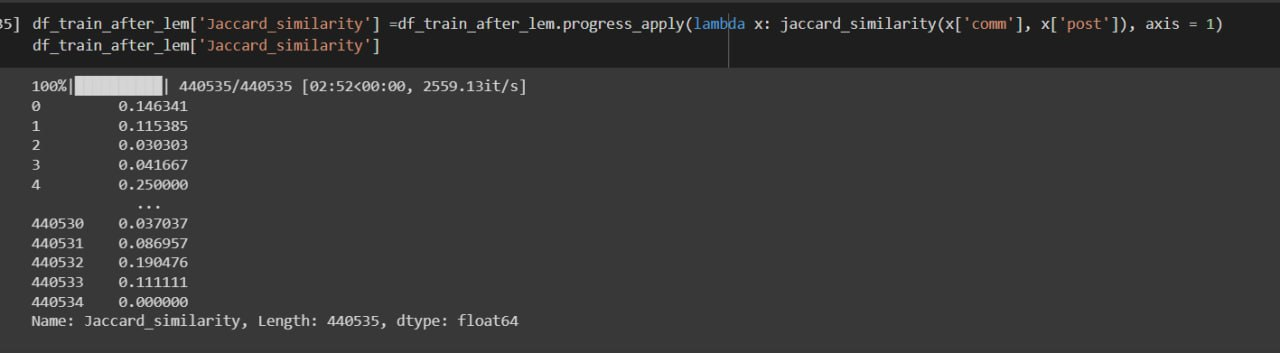

In [ ]:
df_test

In [83]:
df_test['comm']=df_test['comm'].fillna('+')
df_test['post']=df_test['post'].fillna('+')

In [84]:
from tqdm.notebook import tqdm
tqdm.pandas()
df_test['similar_with_Jaccard'] = df_test.progress_apply(lambda x: jaccard_similarity(x['comm'], x['post']), axis=1)
df_test['similar_with_Jaccard2_1']=df_test['similar_with_Jaccard']*df_test['similar_with_Jaccard']*(1-df_test['similar_with_Jaccard'])

  0%|          | 0/70020 [00:00<?, ?it/s]

In [89]:
cos_p_c = []
for i in tqdm_notebook(range(0,len(test_comm_embs))):
    cos_p_c.append(cosine_similarity((test_comm_embs[i],test_post_embs[i]))[1][0])
df_test['post_comm']=cos_p_c
df_test['post_comm2_1']=df_test['post_comm']*df_test['post_comm']*(1-df_test['post_comm'])

  0%|          | 0/70020 [00:00<?, ?it/s]

In [92]:
cos_c_c_mean = []
cos_c_c_max = []
cos_c_c_min = []
for i in tqdm_notebook(range(0,len(test_comm_embs))):
    uid= df_test.iloc[i]['uid']
    ind = df_test[df_test['uid']==uid].index.tolist()
    ind.remove(i)
    list_cos = []
    for j in ind:
        list_cos.append(cosine_similarity((test_comm_embs[j],test_comm_embs[i]))[1][0])    
    cos_c_c_mean.append(np.mean(list_cos)) 
    cos_c_c_max.append(max(list_cos))
    cos_c_c_min.append(min(list_cos))
df_test['comm_comm_mean']=cos_c_c_mean
df_test['comm_comm_max']=cos_c_c_max
df_test['comm_comm_min']=cos_c_c_min

  0%|          | 0/70020 [00:00<?, ?it/s]

In [93]:
analyzer = SentimentIntensityAnalyzer()

df_test['sent_score']=df_test['comm'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_test['post_sent_score']=df_test['post'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_test['post_and_comm_sent']=(df_test['post_sent_score']*df_test['sent_score'] > 0).astype('int64')
df_test=df_test.drop('post_sent_score',axis=1)

In [94]:
df_test

,uid,rank,comm,post,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,similar_with_Jaccard2_1,post_comm,post_comm2_1,comm_comm_mean,comm_comm_max,comm_comm_min,sent_score,post_and_comm_sent
0,88107,NaN,wait stabilize wifi pad sith io quality start ...,io release break phone model withdraw,27,1,0.000000,0,0,0,0.066667,0.004148,0.845085,0.110635,0.889150,0.946946,0.809826,0.0000,0
1,88107,NaN,upgrade restore optionclick update downgrade b...,io release break phone model withdraw,23,4,0.000000,0,0,0,0.000000,0.000000,0.864109,0.101467,0.892799,0.921799,0.870004,0.2960,0
2,88107,NaN,upgrade shortly release suffer consequence res...,io release break phone model withdraw,47,0,0.000000,0,0,0,0.043478,0.001808,0.852067,0.107402,0.907617,0.946946,0.840996,-0.2500,0
3,88107,NaN,lot pressure health kit front big flagship io ...,io release break phone model withdraw,49,1,0.000000,0,0,1,0.083333,0.006366,0.838686,0.113467,0.878200,0.921834,0.800234,-0.2023,0
4,88107,NaN,fix update url,io release break phone model withdraw,7,3,0.000000,0,0,0,0.000000,0.000000,0.820896,0.120693,0.838114,0.901399,0.800234,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70015,102110,NaN,send lot email month email newsletter business...,gmail hate domain,152,4,0.001117,0,0,0,0.042553,0.001734,0.796243,0.129183,0.934971,0.947039,0.916609,-0.4404,1
70016,102110,NaN,hit si ilar problem send automate internal ema...,gmail hate domain,31,0,0.000000,0,0,0,0.000000,0.000000,0.862990,0.102039,0.921032,0.925867,0.916609,-0.6597,1
70017,102110,NaN,bit pre sum pti inflammatory amount pure specu...,gmail hate domain,57,1,0.000000,0,0,0,0.000000,0.000000,0.845314,0.110532,0.935584,0.947669,0.918152,-0.5423,1
70018,102110,NaN,domain url mail server host server hetzner sco...,gmail hate domain,70,1,0.000000,0,0,0,0.030303,0.000890,0.814647,0.123009,0.941121,0.948388,0.923499,0.5719,0


In [95]:
df_test.to_csv('test_after_lem.csv', index=False)